In [1]:
#Define showcode button action
from IPython.display import HTML
showcode='''
<style>
.button {
    background-color: #e7e7e7;
    color: black; /* Green */
    border: none;
    padding: 5px;
    text-align: center;
    text-decoration: none;
    display: inline-block;
    font-size: 10px;
    margin: 2px 2px;
    cursor: pointer;
}
.button5 {border-radius: 50%;}
</style>
<script>
  function code_toggle() {
    if (code_shown){
      $('div.input').hide('500');
      $('#toggleButton').val('Show Code')
    } else {
      $('div.input').show('500');
      $('#toggleButton').val('Hide Code')
    }
    code_shown = !code_shown
  }

  $( document ).ready(function(){
    code_shown=false;
    $('div.input').hide()
  });
</script>
<form action="javascript:code_toggle()"><input type="submit" id="toggleButton" value="Show Code" class="button button5"></form>

'''

In [3]:
#Import moudles
%matplotlib inline
import mpld3
mpld3.enable_notebook()
from collections import OrderedDict
import pandas as pd
import numpy as np
import xarray as xr
import glob
from netCDF4 import Dataset as nc, num2date, MFDataset as mc, date2num
import os
import pytz
from matplotlib import pyplot as plt
import plotly.plotly as py
import plotly.graph_objs as go
import seaborn as sns
import cufflinks as cf
cf.set_config_file(offline=False, world_readable=True, theme='ggplot')
sns.set_style("whitegrid")
from DataFrame import *
from datetime import datetime
from datetime import timedelta as td
from astropy.stats import LombScargle
import astropy.units as u
from scipy import signal
import matplotlib, sys
from mpl_toolkits.basemap import Basemap, cm as colmap
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = [30.0,30.0]
from collections import namedtuple
timezone = pytz.timezone('Australia/Darwin')
utc = pytz.UTC
from matplotlib import animation, rc
from matplotlib.colors import LightSource
from matplotlib.colorbar import cm as colmap2
from matplotlib.patches import Polygon

from matplotlib import animation, rc
from matplotlib.colors import LightSource
from matplotlib.colorbar import cm as colmap2
from matplotlib.patches import Polygon
import palettable as colortable
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 24}

matplotlib.rc('font', **font)
from palettable.mycarta import LinearL_20, CubeYF_20
from palettable.colorbrewer.qualitative import Paired_12
from brewer2mpl import qualitative
np.warnings.filterwarnings('ignore')
from plotly import tools
from tint.visualization import plot_traj, get_plotly_traj
from netCDF4 import Dataset as nc
from matplotlib import dates
from tint.visualization import make_mp4_from_frames
# Turn on LaTeX formatting for text    
plt.rcParams['text.usetex']=True
import io
import base64
from IPython.display import HTML
from netCDF4 import num2date
import h5py
# Place the command in the text.latex.preamble using rcParams
plt.rcParams['text.latex.preamble']=r'\makeatletter \newcommand*{\rom}[1]{\expandafter\@slowromancap\romannumeral #1@} \makeatother'

In [ ]:
def embed_vid(outvid):
    video = io.open(outvid, 'r+b').read()
    encoded = base64.b64encode(video)
    return HTML(data='''<video alt="test" width="950" height="500" loop="true" controls>
                <source src="data:video/mp4;base64,{0}" type="video/mp4" loop="true" />
             </video>'''.format(encoded.decode('ascii')))

# Storm Track Analysis

In [5]:
HTML(showcode)

In [6]:
# Define some paths
CPOLF = os.path.join(os.environ['HOME'], 'Data', 'Extremes', 'CPOL', 'CPOL_TIWI_1998-2017-old.nc')
WOHF = os.path.join(os.environ['HOME'], 'Data', 'Extremes', 'CPOL', 'CPOL_WOH.nc')
CMORPHF = os.path.join(os.environ['HOME'], 'Data', 'Extremes', 'UM', 'CMORPH_V1_WOH.nc')
WOHFv1 = os.path.join(os.environ['HOME'], 'Data', 'Extremes', 'CPOL', 'CPOL_WOHv1.nc')
WOHFv2 = os.path.join(os.environ['HOME'], 'Data', 'Extremes', 'CPOL', 'CPOL_WOHv2.nc')
BurstF = os.path.join(os.environ['HOME'], 'Data', 'Extremes', 'CPOL', 'CPOL_burst-cmorph.pkl')
PercF = os.path.join(os.environ['HOME'],'Data','Extremes','CPOL','CPOL_TIWI_Percentiles-old.hdf5')
extremeTS = os.path.join(os.environ['HOME'],'Data','Extremes','CPOL','CPOL_TIWI_TS_extrme.pkl')
PopeF = os.path.join(os.environ['HOME'], 'Data', 'Extremes', 'CPOL','Pope_Regimes.pkl')
Cpol_tF = os.path.join(os.environ['HOME'], 'Data', 'Extremes', 'CPOL','CPOL_tracks.pkl')
percf =  os.path.join(os.environ['HOME'],'Data','Extremes','CPOL', 'Periods.npz')
outdir = os.path.join(os.getenv('HOME'),'Data','Extremes','UM', 'Plot', 'Week_of_Hector')
geodataf = os.path.join(os.getenv('HOME'), 'Data', 'Extremes', 'UM')
trackfile = 'tint_tracks_2006_11_10_00-2006_11_18_23-old.pkl'
CPOL_trackdir = os.path.join(os.getenv('HOME'),'Data', 'Extremes','CPOL', 'Tracking')
CPOL_trackfile =  os.path.join(CPOL_trackdir, trackfile)
remap_res = '2.5km'
target_regime = 5
UMdir = os.path.join(os.getenv('HOME'), 'Data', 'Extremes', 'UM', 'darwin', 'RA1T')
popeR  = pd.read_pickle(PopeF)

In [264]:
# Define the function that creates the average track information
from math import sin, cos, sqrt, atan2, radians
def dist(p1, p2, dd=2):
    ## approximate radius of earth in km
    R = 6373.0
    lat1 = radians(p1[1])
    lon1 = radians(p1[0])
    lat2 = radians(p2[1])
    lon2 = radians(p2[0])

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = dd * atan2(sqrt(a), sqrt(1 - a))

    return  R * c

def get_mean(data_file, res=2.5, coldpool=False):
    if isinstance(data_file, str):
        dataset = pd.read_pickle(data_file)
    else:
        dataset = data_file
    columns=['avg_mean','avg_area', 'avg_max', 'max_mean', 'max_area', 'max_max',
             'std_mean', 'std_area', 'std_max','dur', 'dist', 'v', 'uid']
    lookup = ['max', 'mean', 'area', 'time', 'lon', 'lat']

    if coldpool:
        lookup +=  ['cp_max', 'cp_mean', 'cp_area', 'cp_dur']
        columns += ['cp_max', 'cp_mean', 'cp_area', 'cp_dur']
        

    dataset = dataset[dataset.isolated][lookup]
    
    uid = np.array(dataset.index.get_level_values('uid')).astype('i')
    uid.sort()
    values=np.empty((1,len(columns)))
    index = []
    for nn, idx in enumerate(np.unique(uid)):
        try:
            df = pd.DataFrame(dataset.xs(str(idx), level='uid').values, columns=dataset.columns)
        except (TypeError, KeyError):
            df = pd.DataFrame(dataset.xs(idx, level='uid').values, columns=dataset.columns)
        if len(df):
            dur = (df['time'].max() - df['time'].min()).total_seconds()/60.
            if dur > 20:
                path = df[['lon','lat']].values    
                d = np.array([dist(path[i], path[i+1]) for i in range(0,len(df)-1,2)]).sum()
                mean = df[['mean','area','max']].mean().values
                Max = df[['mean','area','max']].max().values
                std = df[['mean', 'area', 'max']].std().values
                
                v = d/(dur/60.)
                uid = np.array([int(idx)])
                index.append(nn)
                if coldpool:
                    cp = df[['cp_max', 'cp_mean', 'cp_area','cp_dur']].mean().values
                    values= np.append(values, np.r_[mean, Max, std, dur, d, v, uid, cp][np.newaxis],axis=0)
                else:
                    values= np.append(values, np.r_[mean, Max, std, dur, d, v, uid][np.newaxis],axis=0)
    out = pd.DataFrame(values[1:,], index=index, columns=columns)
    for area in ('avg_area', 'max_area'):
        out[area] = out[area] * res**2
    #out = out.loc[out.dist > 10]
    out.index=np.arange(len(out))
    return xr.Dataset(out)
def get_coldpools(dataset, coldpools, td='10 min', res=2.5):
    dataset = dataset[dataset.isolated][['max', 'mean', 'area', 'time', 'lon', 'lat', 'isolated']]
    coldpool = {}
    for v in ['cp_max', 'cp_mean', 'cp_area', 'cp_dur']:
        dataset[v] = np.nan
        coldpool[v] = dataset[v].values
    for n,i in enumerate(dataset.index):
        time = (dataset.loc[i]['time'] + pd.Timedelta(td)).round('10 min')
        scan = (coldpools['time'] - time).abs().argmin()[0]
        cps = coldpools.xs(scan, level='scan')#[['mean', 'max','time', 'lat', 'lon']])
        dt = np.fabs((pd.DatetimeIndex(cps['time'].values) - pd.Timestamp(time)).total_seconds())
        if dt.values.max()/60 < 30:
            co1 = cps[['lon', 'lat']].values
            co2 = dataset.loc[i][['lon','lat']].values
            cdist = np.apply_along_axis(dist, 1, co1, tuple(co2), dd=1)
            maxcdist = 2*np.sqrt(dataset.loc[i]['area']*res**2/np.pi)
            uid=cps.index[cdist.argmin()]
            cp_time = pd.DatetimeIndex(coldpools.xs(uid, level='uid')['time'].values)
            dur = (cp_time.max() - cp_time.min()).total_seconds()/60
            if cdist.min() < maxcdist*2:
                for v in coldpool.keys():
                    try:
                        coldpool[v][n] = cps[v.replace('cp_','')].values[cdist.argmin()]
                    except KeyError:
                        coldpool['cp_dur'] = dur 
    for v in coldpool.keys():
        dataset[v] = coldpool[v]
    return dataset
tmp = get_coldpools(tracks.dataset[ens], tracks.coldpools[ens])

In [176]:
# Define our ensemble member
ensembles = ('20061109T1200Z', '20061109T1800Z', '20061110T0000Z',
             '20061110T0600Z', '20061110T1200Z', '20061110T1800Z',
             '20061111T0000Z', '20061111T1200Z')

In [266]:
#Create the named-tuple containing the avg. track data
Simulation = namedtuple('Simulation', 'dataset, num, percentiles coldpools resolution')
CPOL_type = namedtuple('Simulation', 'dataset, num, percentiles resolution')
UM133 = Simulation(dataset={}, num={}, percentiles={}, coldpools={} ,resolution='1p33km')
UM044 = Simulation(dataset={}, num={}, percentiles={}, coldpools={}, resolution='0p44km')
UM044_t = Simulation(dataset={}, percentiles={}, num={}, coldpools={}, resolution='0p44km')
UM133_t = Simulation(dataset={}, percentiles={}, num={}, coldpools={}, resolution='1p33km')
P = list(np.arange(0,99))+[99, 99.9, 99.99, 99.999, 100]
CPOL_t = CPOL_type(dataset={'obs': pd.read_pickle(CPOL_trackfile)}, num={} ,percentiles={}, resolution='2.5km')
OBS = CPOL_type(dataset=dict(obs=get_mean(CPOL_t.dataset['obs'])), num={}, percentiles={}, resolution='2.5km')
p1 = np.percentile(CPOL_t.dataset['obs']['mean'],P)
p2 = np.percentile(CPOL_t.dataset['obs']['max'],P)
CPOL_t.percentiles['obs'] = dict(mean=p1, max=p2)
CPOL_t.num['obs'] = len(CPOL_t.dataset['obs'])
OBS.num['obs'] = len(OBS.dataset['obs'])
for ens in ensembles:
        for mean, tracks in ((UM133, UM133_t), (UM044, UM044_t)):
            cold_pool_f = glob.glob(os.path.join(UMdir, ens, 'darwin', mean.resolution, 'Tracking', '*.hdf5'))[0]
            track_f = glob.glob(os.path.join(UMdir, ens, 'darwin', mean.resolution, 'Tracking', '*.pkl'))[0]
            tracks.dataset[ens] = pd.read_pickle(track_f)
            tracks.coldpools[ens] =  pd.read_hdf(cold_pool_f, 'coldpool')
            mean.dataset[ens] = get_mean(get_coldpools(tracks.dataset[ens], tracks.coldpools[ens]), coldpool=True)
            mean.coldpools[ens] = get_mean(tracks.coldpools[ens])
            p1 = np.percentile(tracks.dataset[ens]['mean'],P)
            p2 = np.percentile(tracks.dataset[ens]['max'],P)
            tracks.percentiles[ens] = dict(max=p2, mean=p1)
            tracks.num[ens] = len(tracks.dataset[ens])
            mean.num[ens] = len(mean.dataset[ens])

In [267]:
#Define a function that stacks tracks
def stack_tracks(Dir, prefix='tint'):
    if prefix == 'tint':
        track_files = glob.glob(os.path.join(Dir, '%s_tracks_????_??_??_??-????_??_??_??.pkl'%prefix))
        track_files.sort()
        df = pd.read_pickle(track_files[0])
    else:
        track_files = glob.glob(os.path.join(Dir, '%s_tracks_????_??_??_??-????_??_??_??.hdf5'%prefix))
        track_files.sort()
        df = pd.read_hdf(track_files[0], 'coldpool')   

    n_uid=np.array(df.index.get_level_values('uid')).astype('i')
    n_scan =np.array(df.index.get_level_values('scan'))
    df.index = pd.MultiIndex.from_tuples(list(zip(n_scan, n_uid)), names=('scan','uid'))
    #
    scan_last, uid_last = df.index[-1]
    for tf in track_files[1:]:
        tmp_df = pd.read_pickle(tf)
        if len(tmp_df):
            n_uid=np.array(tmp_df.index.get_level_values('uid')).astype('i')+1+int(uid_last)
            n_scan =np.array(tmp_df.index.get_level_values('scan'))+1+scan_last
            tmp_df.index = pd.MultiIndex.from_tuples(list(zip(n_scan, n_uid)), names=('scan','uid'))
            df = pd.concat([df, tmp_df])
            scan_last, uid_last = df.index[-1]
        #break
    df.time = df.time.dt.round('10min')
    return df
#df1 = stack_tracks(CPOL_trackdir)

In [268]:
#Stack the dataframes
try:
    CPOL_total = pd.read_pickle(Cpol_tF)
except Exception:
    #pass
    CPOL_total = stack_tracks(CPOL_trackdir)
    CPOL_total.to_pickle(Cpol_tF)

In [269]:
CPOL_total['month'] = pd.DatetimeIndex(CPOL_total.time.values).month.values
CPOL_total['year'] = pd.DatetimeIndex(CPOL_total.time.values).year.values
CPOL_total = CPOL_total.loc[CPOL_total['month'] == 11]
#CPOL_total = CPOL_total.loc[CPOL_total['year'] == 2006]
#Get the tracks in target regime 
idx=popeR[CPOL_total.time.values].values
CPOL_total['Regime'] = idx
CPOL_total = CPOL_total.loc[CPOL_total.Regime == target_regime]

In [270]:
CPOL_t.dataset['total'] = CPOL_total
#CPOL_t.dataset['total'] = CPOL_total.loc[CPOL_total.Regime == target_regime]
CPOL_t.dataset['total'] = CPOL_t.dataset['total'].loc[CPOL_t.dataset['total'].year <= 2008]

In [271]:
#Now get the mean tracking information for those tracks
OBS.dataset['total']=get_mean(CPOL_total)
p1 = np.percentile(CPOL_t.dataset['total']['mean'],P)
p2 = np.percentile(CPOL_t.dataset['total']['max'],P)
CPOL_t.percentiles['total'] = dict(mean=p1, max=p2)
OBS.num['total'] = len(OBS.dataset['total'])

In [272]:
keys=['obs']
obs_idx = OBS.dataset['obs'].to_dataframe().index
rmax = OBS.dataset['obs'].to_dataframe()['avg_mean'].max()
tmp_df = OBS.dataset['total'].to_dataframe()
for i in range(20):
    tmp = tmp_df.loc[tmp_df['avg_mean'] <= rmax].sample(len(obs_idx)//2)
    #tmp = tmp_df.sample(len(obs_idx))
    tmp2 = OBS.dataset['obs'].to_dataframe().sample(len(obs_idx)//2)
    tmp2.idx = obs_idx[len(obs_idx)//2:]
    tmp = pd.concat([tmp, tmp2], axis=0)
    tmp.index = obs_idx[:]
    OBS.dataset['m%02i'%i] = xr.Dataset(tmp)
    keys.append('m%02i'%i)

In [273]:
#Create tracking info ensemble
UM133_ens = xr.concat(UM133.dataset.values(), dim='ens')
UM044_ens = xr.concat(UM044.dataset.values(), dim='ens')
UM133_ens_cp = xr.concat(UM133.coldpools.values(), dim='ens')
UM044_ens_cp = xr.concat(UM044.coldpools.values(), dim='ens')
CPOL = xr.concat([OBS.dataset[s] for s in keys], dim='ens')

In [277]:
uid=np.array(CPOL_t.dataset['obs'].index.get_level_values('uid')).astype('i')
uid.sort()
len(np.unique(uid))
len(UM044_ens.coords['dim_0'])

73

In [206]:
#Define some functions
def get_quant(df, **kwargs):
    try:
        quant = kwargs['quant']
    except KeyError:
        quant={1:(0,0.2), 2:(0.2,0.4), 3:(0.4, 0.6), 4:(0.6,0.8), 5:(0.8,1)}
    try:
        rain = kwargs['rain']
    except KeyError:
        rain='avg_mean'
    for n, q in quant.items():
        Q = df[rain].quantile(q)
        df.quant.loc[(df[rain]>= Q[q[0]]) & (df[rain]<Q[q[1]]) ] = int(n)
    return df
        
        
def ravel(ens_data, run='Cpol', **kwargs):
    pdf = {}
    for var in dict(ens_data.variables).keys():
        if not var.startswith('dim') :
            pdf[var] = ens_data[var].values.ravel()
            pdf[var] = pdf[var][pdf[var] != np.nan]
    df = pd.DataFrame(pdf).dropna()
    run_n = [run for i in range(len(df))]
    df['run'] = run_n
    df['quant'] = np.zeros(len(df), dtype='i')
    df.index = np.arange(len(df))+1
    return get_quant(df, **kwargs)
UM133_pdf, UM044_pdf, CPOL_pdf = ravel(UM133_ens, 'UM 1.33km'), ravel(UM044_ens, 'UM 0.44km'), ravel(CPOL, 'Cpol')
UM133_pdf_cp, UM044_pdf_cp = ravel(UM133_ens_cp, 'UM 1.33km'), ravel(UM044_ens_cp, 'UM 0.44km')
def matplotlib_to_plotly(cmap, pl_entries, rgb=True):
    h = 1.0/(pl_entries-1)
    pl_colorscale = []
    for k in range(pl_entries):
        C = list(map(np.uint8, np.array(cmap(k*h)[:3])*255))
        if rgb:
            pl_colorscale.append([k*h, 'rgb'+str((C[0], C[1], C[2]))])
        else:
            pl_colorscale.append(tuple(np.array(C)/255))

    return pl_colorscale

The tracking algorithm is a fork of the Tint (Tint is not Titan) tracking algorithm ([http://openradarscience.org/TINT/](http://openradarscience.org/TINT/)). The framework has been modified that it can be also applied to model output data that is not not stored in [Py-ART](http://arm-doe.github.io/pyart) radar data container.

- The analysis is based averages of one week worth of strome cell tracking:

### 1. Median of strom area, duration, avg., max. rain-rates and # of storm cells

In [207]:
#Plot the Medians
um044_n = len(UM044_ens.coords['dim_0'])
um133_n = len(UM133_ens.coords['dim_0'])
cpol_n = len(OBS.dataset['total'].coords['dim_0'])
cpol_n2 = len(CPOL.coords['dim_0'])
CPOL_pdf2 = ravel(OBS.dataset['obs'])
var=['avg_area','dur', 'avg_mean', 'max_mean', 'dist', 'v']
names=['area', 'duration', 'avg-rain', 'max-rain', 'distance', 'speed', '# storms']
#print(CPOL_pdf[var].median())
medians = pd.DataFrame({'a': list(CPOL_pdf[var].median().values)+[int(cpol_n)],
                        'b': list(CPOL_pdf2[var].median().values)+[int(cpol_n2)],
                        'd': list(UM044_pdf[var].median().values)+[int(um044_n)],
                        'c': list(UM133_pdf[var].median().values)+[int(um133_n)]} )
                       #index=('Area','Duration', 'Mean-Rain', 'Max-Rain'))
medians.index=names
medians.columns=['Bootstrap', 'Cpol', 'UM 1.33km', 'UM 0.44km']
#print('Medians:')
                 
medians.round(2)

Bootstrap    Cpol  UM 1.33km  UM 0.44km
area         111.20  119.38      81.64      67.34
duration      60.00   74.67      60.00      60.00
avg-rain       4.52    4.50       4.91       5.93
max-rain       6.58    6.60       7.37       9.06
distance      15.10   16.42      10.60      12.09
speed         12.61   12.83      10.03      12.78
# storms    1184.00   42.00      50.00      73.00

### 2. 2D-Histograms (storm area vs duration):

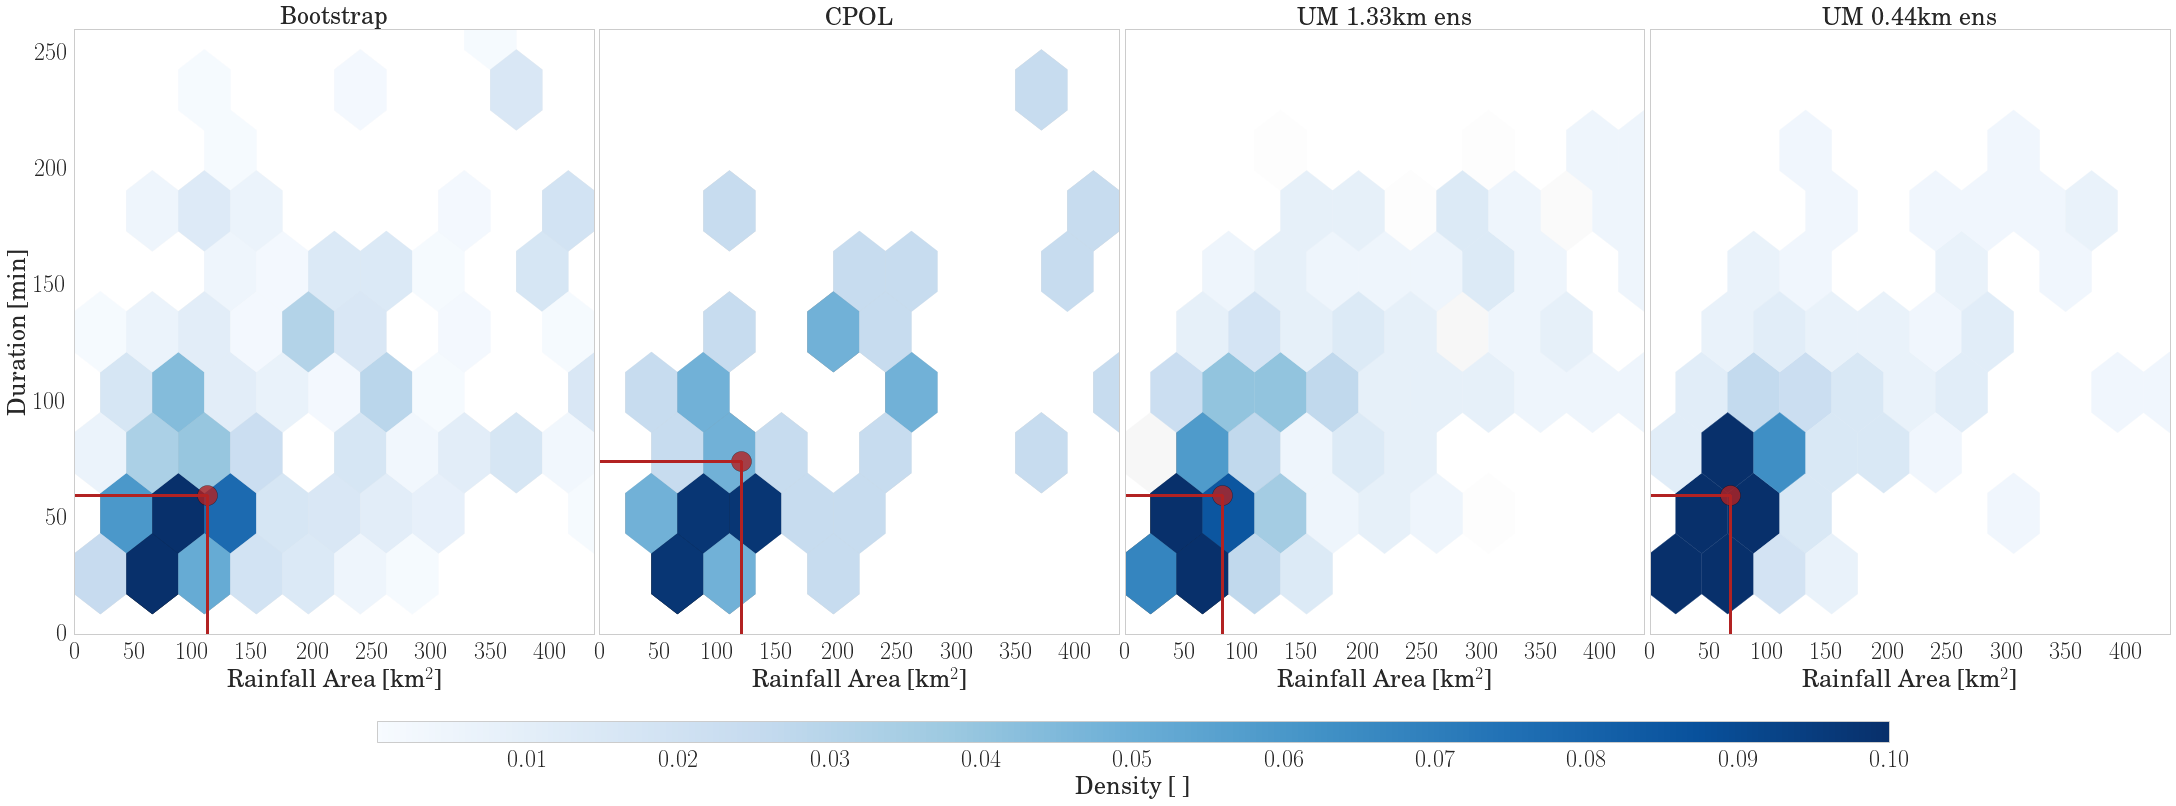

In [208]:
#Create Hex-Bin plot
mpld3.disable_notebook()
var=['avg_area','dur', 'max_mean', 'avg_mean']
medians = pd.DataFrame({ 'Bootstrap':CPOL_pdf[var].median(),
                        'CPOL':CPOL_pdf2[var].median(),
                        'UM 1.33km':UM133_pdf[var].median(),
                        'UM 0.44km':UM044_pdf[var].median()})
#medians.loc['avg_area'] /= 2.5**2
histdata =  [UM044_pdf[var].dropna(), UM133_pdf[var].dropna(), CPOL_pdf2[var].dropna(), CPOL_pdf[var]][::-1]
titles = ['UM 0.44km ens', 'UM 1.33km ens', 'CPOL', 'Bootstrap'][::-1]
fig = plt.figure(figsize=(10,8))
colm = colmap2.Blues
colm.set_under('w', alpha=0)
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, sharey=True)
fig.subplots_adjust(bottom=0.07, right=0.98, left=0.01, top=0.35, wspace=0.01)
cbar_ax = fig.add_axes([0.15, 0.02, 0.7, 0.01])
hexbin_data = []
gridsize = 10
vmin=0.0001
vmax=0.1
nticks=10
YMax, XMax = 260, 70*2.5**2
#YMax, XMax = 50, 70*2.5**2
for i, ax in enumerate((ax1, ax2, ax3, ax3)):
    data = histdata[i][var[:2]]
    #data[var[0]] /= 2.5**2
    #data = data.loc[(data[var[0]] <= XMax) & (data[var[1]] <=YMax)]
    X = data[var[0]].values
    Y = data[var[1]].values
    ax.set_ylim(0,YMax)
    ax.set_xlim(0,XMax)
    hb =  ax.hexbin(X, Y,  gridsize=gridsize, extent=(0,XMax,0,YMax))
    hexbin_data.append(np.ones_like(Y, dtype=np.float) / hb.get_array().sum())
    
cl = plt.cla()
medians = OrderedDict()

for i, ax in enumerate((ax1, ax2, ax3, ax4)):
    data = histdata[i][var[:2]]
    #data[var[0]] /= 2.5**2
    #data = data.loc[(data[var[0]] <= XMax) & (data[var[1]] <=YMax)]
    X = data[var[0]].values
    Y = data[var[1]].values
    ax.set_ylim(0,YMax)
    ax.set_xlim(0,XMax)
    im = ax.hexbin(X, Y,  gridsize=gridsize, cmap=colm, marginals=False, extent=(0,XMax,0,YMax),
                     vmin=vmin, vmax=vmax, C=hexbin_data[i], reduce_C_function=np.sum)
    
    ax.set_title(titles[i], fontsize=24)
    ax.grid(color='w', linestyle='', linewidth=0)
    ax.tick_params(labelsize=24)
    ax.xaxis.set_ticks(ax.xaxis.get_ticklocs()[:-1])
    x, y = histdata[i][var[0]].median(), histdata[i][var[1]].median()
    z, zz=  histdata[i][var[2]].median(), histdata[i][var[-1]].median()
    sx, sy = histdata[i][var[0]].std(), histdata[i][var[1]].std()
    medians[titles[i]] = '%2.1f km^2, %2i min (max: %2.1f mm/h, mean: %2.1f mm/h);'%(x,y, z, zz)
    ax.hlines(y*np.ones_like(histdata[i][var[0]]),0,x, 'firebrick', lw=3)
    ax.vlines(x*np.ones_like(histdata[i][var[1]]),0,y, 'firebrick', lw=3)
    ax.scatter([x], [y], marker='o', s=400, c='firebrick', alpha=0.8)
    if i == 0:
        ax.set_ylabel('Duration [min]', fontsize=24)
    ax.set_xlabel('Rainfall Area [km$^2$]', fontsize=24)
ary=im.get_array()/im.get_array().sum() * 100
im.set_array = ary
cbar = fig.colorbar(im, cax=cbar_ax, orientation='horizontal')
tmp = cbar.ax.tick_params(labelsize=24)
tmp = cbar.set_label('Density [ ]',size=24)
#cbar.set_ticks(np.linspace(vmin, vmax, nticks).round(2))
#cbar.set_ticklabels(np.linspace(vmin, vmax, nticks).round(2))
#print('Medians:')
#medians
#print(' '.join(['%s: %s'%(k, v) for (k,v) in medians.items()]))
#plt.show()

In [34]:
colm = matplotlib_to_plotly(CubeYF_20.get_mpl_colormap(N=8, gamma=2.0),8, rgb=False)

### 3. Storm tracks above the 80th percentiles
* marks start of track, colors for different ensemble member

In [35]:
#Get the longest strom-tracks
data = OBS.dataset['obs'].to_dataframe().sort_values('dur')
data.loc[data.dur>100].sort_values('avg_mean')
time = CPOL_t.dataset['obs']['time'][:,str(42)]
lat, lon = CPOL_t.dataset['obs']['lat'][:,str(42)].values[0], CPOL_t.dataset['obs']['lon'][:,str(42)].values[0]
a = np.array([lat, lon])
start, end = time.values[0], time.values[-1]
sID = namedtuple('stormID', 'Sim')
storm_UM044 = sID(Sim={})
storm_UM133 = sID(Sim={})
for Id, um in ((storm_UM044, UM044_t), (storm_UM133, UM133_t)):
    for ens, data in um.dataset.items():
        idx = np.unique((data['time'] - start).abs().sort_values()[:20].index.get_level_values('uid')).astype('i')
        d = []
        for uid in idx.astype('str'):
            b = np.array([data['lat'][:,uid].values[0], data['lon'][:,uid].values[0]])
            r = np.linalg.norm(a-b)
            d.append([uid.astype('i'), r])
        d = int(np.array(d).min(axis=0)[0])
        Id.Sim[ens]=str(d)
storm_obs=sID(Sim={'obs':'42'})

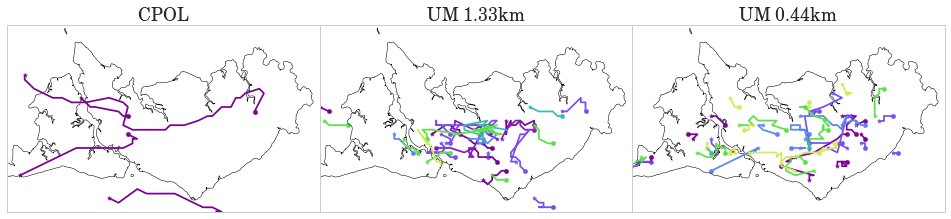

In [43]:
#Plot the tracks
mpld3.enable_notebook()
fig = plt.figure(figsize=(14,5.5))
fig.subplots_adjust(right=0.94, bottom=0.45, top=0.95,left=0.01, hspace=0, wspace=0)
#cbar_ax = fig.add_axes([0.12, 0.17, 0.74, 0.02])
o = namedtuple('Sim', 'dataset percentiles')
tmp_obs = o({'obs': CPOL_t.dataset['obs']}, {'obs': CPOL_t.percentiles['obs']})

with nc(CPOLF) as fnc:
    lon=fnc.variables['longitude'][:]
    lat=fnc.variables['latitude'][:]
tp = 'mean'
num=80
titels = ['CPOL', 'UM 1.33km', 'UM 0.44km']
m = None
for i, data in enumerate(((tmp_obs, storm_obs), (UM133_t, storm_UM133), (UM044_t, storm_UM044))):
    tracks, stormId = data
    ax = fig.add_subplot(1,3,i+1)
    #ax2 = fig.add_subplot(2,3,i+4)
    ax.set_title(titels[i], fontsize=18)
    for ii, tr in enumerate(tracks.dataset.keys()):
        if ii == 0:
            draw_map = None
            m2 = None
        else:
            draw_map = m
        Id = [stormId.Sim[tr]]
        perc = tracks.percentiles[tr][tp][num]
        ax, m, im = plot_traj(tracks.dataset[tr], lon, lat, ax=ax, mintrace=2, thresh=('mean', perc), 
                  color=colm[ii], create_map=draw_map, basemap_res='f', lw=0.5, size=20, particles=None)
        #ax2, m2, im = plot_traj(tracks.dataset[tr], lon, lat, ax=ax2, mintrace=2, thresh=('mean', perc),
        #          color=colm[ii], create_map=m2, basemap_res='f', lw=0.5, size=20, particles=Id)
        #break
#plt.show()

In [24]:
#Plot the tracks with plotly
#fig = plt.figure(figsize=(25,15))
#fig.subplots_adjust(right=0.94, bottom=0.025, top=0.67,left=0.01, hspace=0, wspace=0)
#cbar_ax = fig.add_axes([0.12, 0.17, 0.74, 0.02])
with nc(CPOLF) as fnc:
    lon=fnc.variables['longitude'][:]
    lat=fnc.variables['latitude'][:]
df='''tp = 'mean'
num=80
titels = ['CPOL', 'UM 1.33km', 'UM 0.44km']
data = []
layout =dict(autosize = False)
domains = [[0,.3], [0.33, 0.63], [0.66,0.99]]
ii = 0
data = []
#fig['layout'].update(height=600, width=600,
#fig = tools.make_subplots(rows=1, cols=3, subplot_titles=Titles)
for i, tracks in enumerate((CPOL_t, UM133_t, UM044_t)):
    #ax = fig.add_subplot(1,3,i+1)
    #for tr in tracks.dataset.keys():
    name = 'geo'+str(ii+1) if ii != 0 else 'geo'
    layout[name] = dict(
        domain = dict(x=domains[i], y=[0,1]),
        resolution=50,
        lonaxis =  dict(range = [min(lon), max(lon)]),
        lataxis = dict(range = [min(lat), max(lat)]),
        projection=dict( type='azimuthal equal area', scale=1 ),
        landcolor = 'rgb(243, 243, 243)',
        countrycolor = 'rgb(204, 204, 204)')
    if ii == 0 or ii == 1 or ii == 15:
         text = [titels[i]]
    else:
        text = None
            
    perc = tracks.percentiles[tr][tp][num]
    data += get_plotly_traj(tracks.dataset[tr], thresh_val=perc, thresh='mean',
                                    geo=name, mintrace=2, text=text,showlegend = False)
    ii += 1
    #plot_traj(tracks.dataset[tr], lon, lat, ax=ax, mintrace=2, thresh_val=perc, thresh='mean')
fig = dict( data=data, layout=layout )
py.iplot( fig, filename='storm-tracks' )
'''

In [247]:
#mpld3.disable_notebook()
UM133_pdf, UM044_pdf, CPOL_pdf = ravel(UM133_ens, 'UM 1.33km'), ravel(UM044_ens, 'UM 0.44km'), ravel(CPOL, 'Bootstrp')
CPOL_pdf2 = ravel(OBS.dataset['obs'])
df_stack = pd.concat([CPOL_pdf2, UM133_pdf, UM044_pdf], ignore_index=True)

#df_stack['avg_area'] /= 2.5**2
df_stack['avg_area'].loc[(df_stack['quant']==3) & (df_stack['run']=='Cpol')] /= 1
df_stack['dur'].loc[(df_stack['quant']==4) & (df_stack['run']=='Cpol')] *= 1
#df_stack['quant'] = df_stack['quant'].astype('i')

###  4. Classification of strom area, rain-rate and duration by rain-rate quintiles

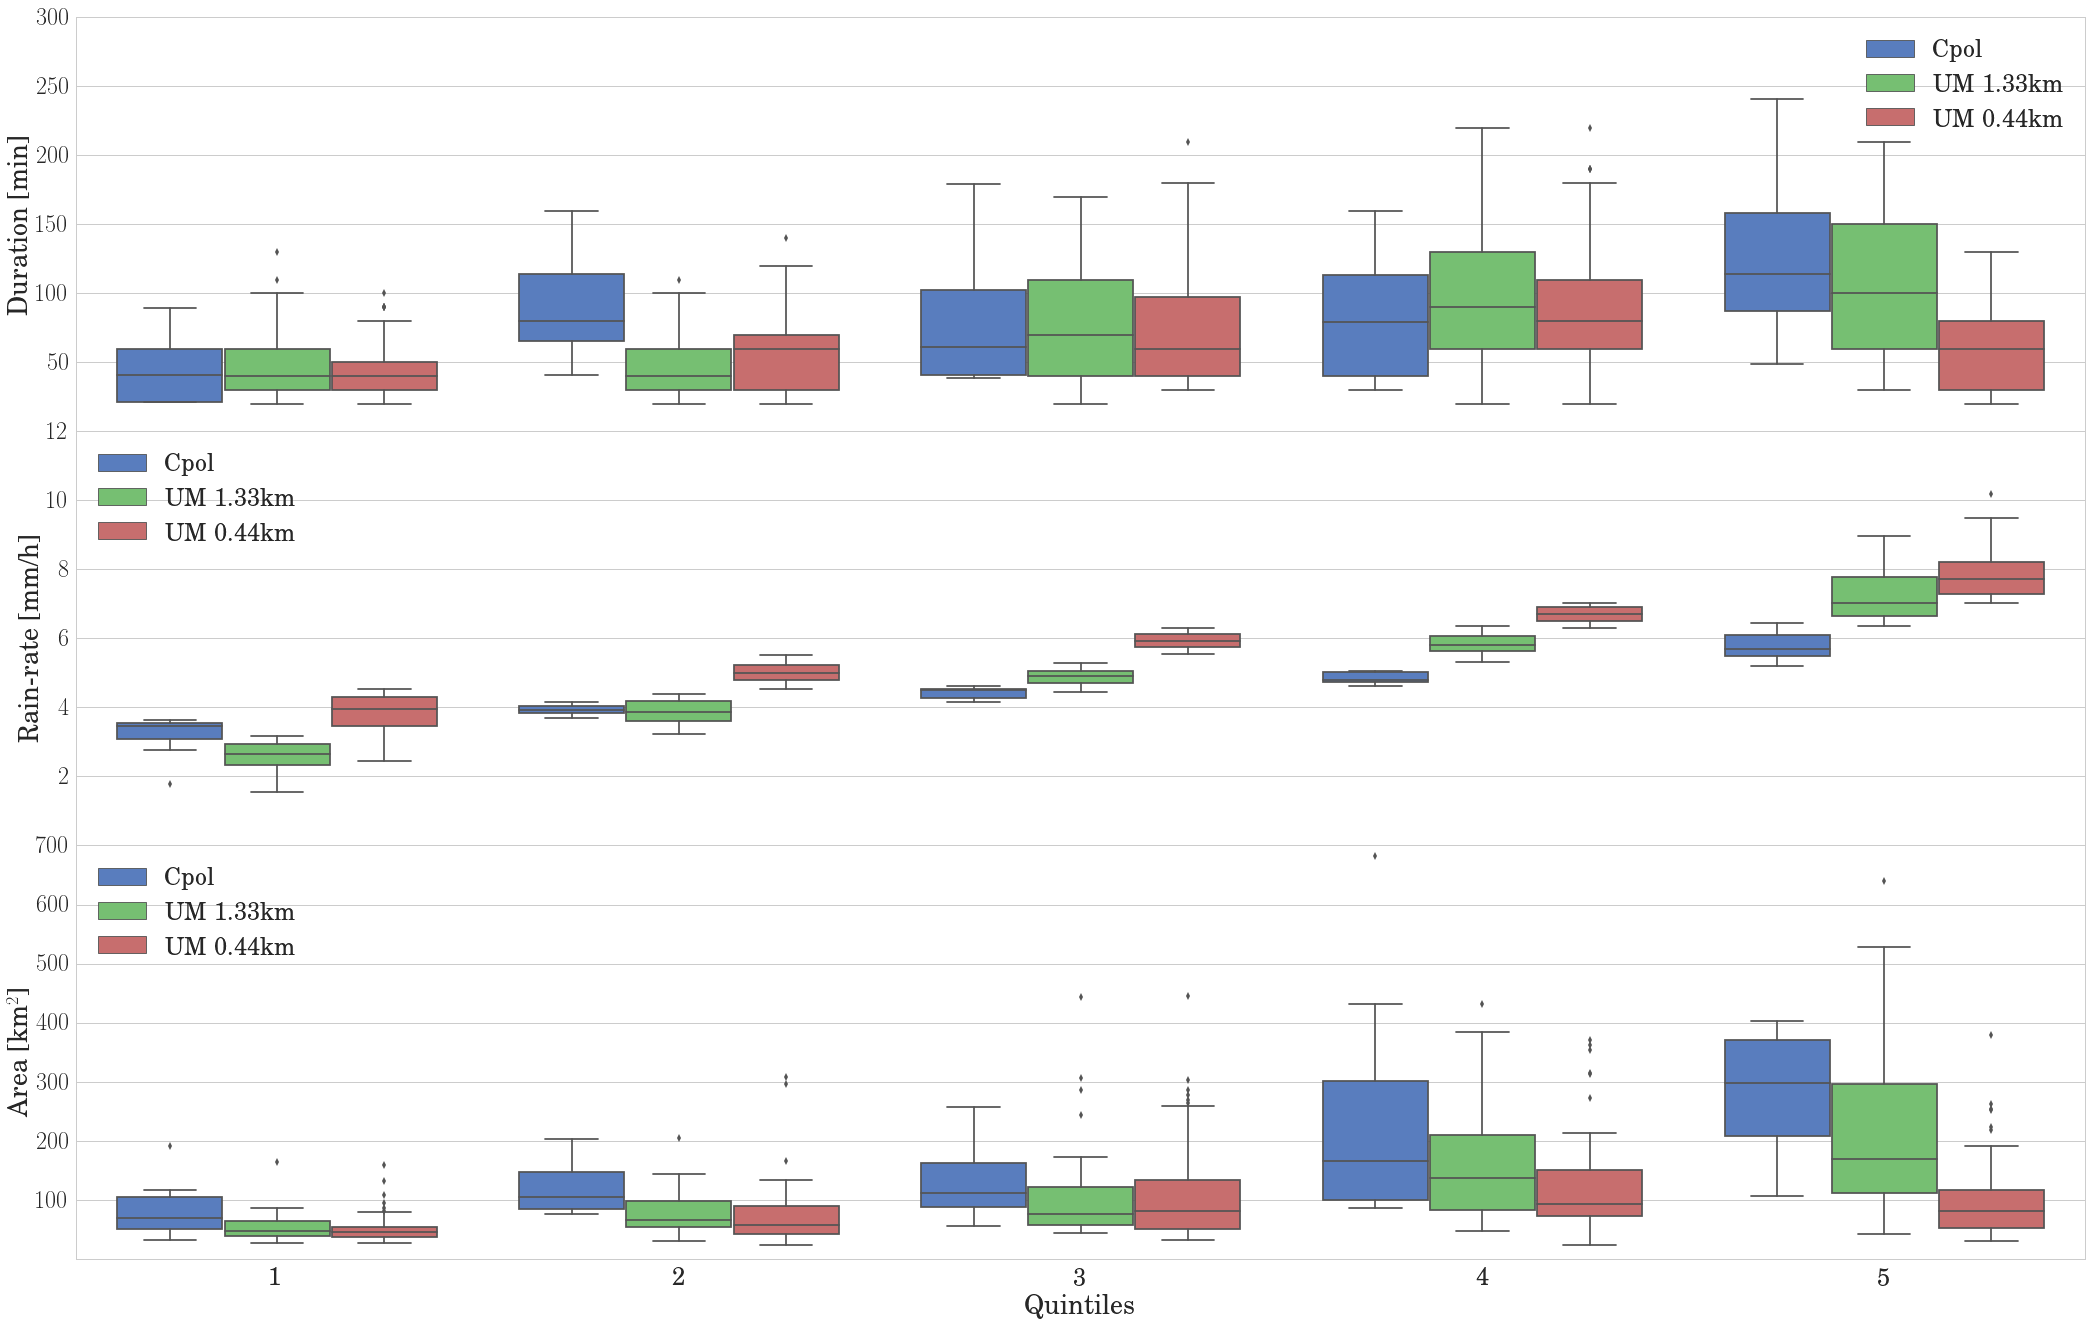

In [259]:
mpld3.disable_notebook()
variables=dict(dur=('Duration [min]',300), avg_area=('Area [km$^2$]', 100*2.5**2), avg_mean=('Rain-rate [mm/h]',12))
fig = plt.figure()
fig.subplots_adjust(right=0.94, bottom=0.025, top=0.6,left=0.01, hspace=0, wspace=0)
i = 0
for y, prop in variables.items():
    label, ylim = prop
    npl = len(list(variables.keys()))
    i += 1
    ax = fig.add_subplot(npl,1,i)
    ax = sns.boxplot(x="quant", y=y, hue="run", data=df_stack, palette="muted", ax=ax)
    #ax = sns.stripplot(x="quant", y=y, hue="run", data=df_stack, jitter=True, palette="Set2", dodge=True)
    ax.legend(loc=0, fontsize=24)
    ax.tick_params(labelsize=24)
    ax.set_xlim(0.5,5.5)
    ax.set_ylim(0,ylim)
    ax.yaxis.set_ticks(ax.yaxis.get_ticklocs()[1:])
    ax.set_xlabel('Quintiles', fontsize=26)
    ax.set_ylabel(label, fontsize=26)
    #break
#fig.savefig(os.path.join(os.environ['HOME'], 'Todds_Rainfall_2.pdf'), bbox_inches='tight', format='pdf', dpi=300)

### 5. Stormtrack Percentiles vs Rain-rate

In [211]:
P = list(np.arange(0,99))+[99, 99.9, 99.99, 99.999, 100]
member=[]
for i in range(4):
    o = OBS.dataset['m%02i'%i]['avg_mean'].values.ravel()
    member.append(np.percentile(o, P))
member=np.array(member)
mem_min = member.min(axis=0)
mem_max = member.max(axis=0)

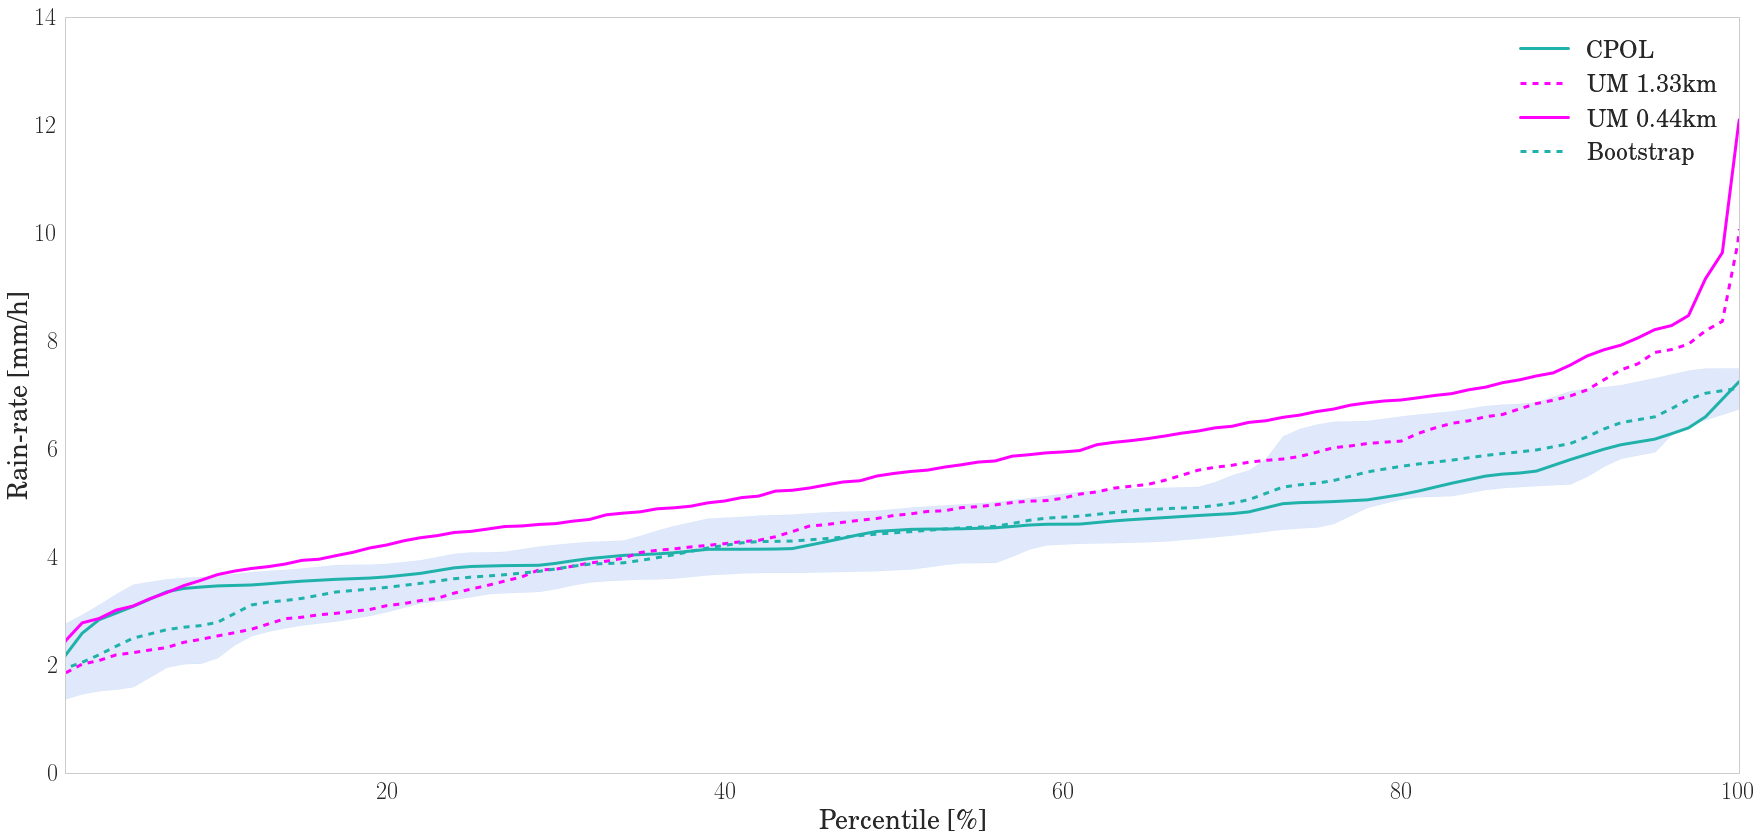

In [516]:
P = list(np.arange(0,99))+[99, 99.9, 99.99, 99.999, 100]

PERC = pd.DataFrame({'Obs':np.percentile(CPOL_pdf2['avg_mean'].values, P), 
                     'UM 1.33km': np.percentile(UM133_pdf['avg_mean'].values, P),
                      'UM 0.44km': np.percentile(UM044_pdf['avg_mean'].values, P)},index=P)

from mpl_toolkits.axes_grid.inset_locator import inset_axes
#Plot the percentages
fig=plt.figure()
ax = fig.add_subplot(111)
plt.subplots_adjust(bottom=0.05, right=0.9, top=0.4)
ax.plot(PERC.index, PERC['Obs'].values, color='lightseagreen', linestyle='-', label='CPOL',lw=3)
ax.plot(PERC.index, PERC['UM 1.33km'].values, color='fuchsia', linestyle='--', label='UM 1.33km',lw=3)
ax.plot(PERC.index, PERC['UM 0.44km'].values, color='fuchsia', linestyle='-', label='UM 0.44km', lw=3)
ax.fill_between(PERC.index, member.min(axis=0)-0.25, member.max(axis=0)+0.25, color='cornflowerblue', alpha=0.2)
ax.plot(PERC.index, member.mean(axis=0), color='lightseagreen', linestyle='--', label='Bootstrap',lw=3)
ax.set_xlim(1,100)
#ax.set_ylim(10,100)
#ax.set_yscale('log')
#ax.set_xscale('log')
ax.set_xlabel('Percentile [\%]', fontsize=26)
ax.set_ylabel('Rain-rate [mm/h]', fontsize=26)
ax.legend(loc=0, fontsize=24)
ax.tick_params(labelsize=24)
ax.grid(color='r', linestyle='-', linewidth=0)

In [27]:
#Bootstrapping stuff:


In [505]:
##Get points 
def bresenham(x0, y0, x1, y1):
    """Yield integer coordinates on the line from (x0, y0) to (x1, y1).
    Input coordinates should be integers.
    The result will contain both the start and the end point.
    """
    dx = x1 - x0
    dy = y1 - y0

    xsign = 1 if dx > 0 else -1
    ysign = 1 if dy > 0 else -1

    dx = abs(dx)
    dy = abs(dy)

    if dx > dy:
        xx, xy, yx, yy = xsign, 0, 0, ysign
    else:
        dx, dy = dy, dx
        xx, xy, yx, yy = 0, ysign, xsign, 0

    D = 2*dy - dx
    y = 0

    for x in range(dx + 1):
        yield x0 + x*xx + y*yx, y0 + x*xy + y*yy
        if D >= 0:
            y += 1
            D -= 2*dx
        D += 2*dy
obs_lon, obs_lat = OBS_grid.dataset[1].variables['longitude'][0,:],\
                   OBS_grid.dataset[1].variables['latitude'][0]

#comp[0]['obs']['lon'].values[0]
idx={}
idx_all={}
for key1 in comp.keys():
    idx[key1]={}
    idx_all[key1]={}
    for key2 in comp[key1].keys():
        if key2 == 'obs':
            lon, lat = OBS_grid.dataset[1].variables['longitude'][0,:],\
                       OBS_grid.dataset[1].variables['latitude'][:,0]
            time = OBS_grid.dataset[1].coords['t'][:]
        elif key2 == 'UM044':
            lon, lat = UM044ens_grid.coords['lon'], UM044ens_grid.coords['lat']
            time = UM044ens_grid.coords['t'][:]
        else:
            lon, lat = UM133ens_grid.coords['lon'], UM044ens_grid.coords['lat']
            time = UM133ens_grid.coords['t'][:]
        idx[key1][key2] = {'loc': [], 'time':[]}
        idx_all[key1][key2] = {'loc': [], 'time':[]}
        idx4 =[]
        for ii in range(len(comp[key1][key2])-1):
            lon1, lon2 = comp[key1][key2]['lon'].values[ii], comp[key1][key2]['lon'].values[ii+1]
            lat1, lat2 = comp[key1][key2]['lat'].values[ii], comp[key1][key2]['lat'].values[ii+1]
            
            idx1 = np.fabs(lon.values-lon1).argmin(), np.fabs(lat.values-lat1).argmin()
            idx2 = np.fabs(lon.values-lon1).argmin(), np.fabs(lat.values-lat2).argmin()
            idx4 += list(bresenham(idx1[0], idx1[1], idx2[0], idx2[1]))
            dt = pd.DatetimeIndex(comp[key1][key2]['time'].values)[ii] - pd.DatetimeIndex(time.values)
            idx3 = np.fabs(dt.total_seconds()).argmin()
            idx[key1][key2]['time'].append(idx3)
            idx_all[key1][key2]['time'].append(idx3)
        for i in range(len(idx4)):
            if idx4[i] not in idx[key1][key2]['loc']:
                idx[key1][key2]['loc'].append(idx4[i])
            idx_all[key1][key2]['loc'].append(idx4[i])
        
        idx[key1][key2]['loc']= np.array(idx[key1][key2]['loc'])
        idx_all[key1][key2]['loc']= np.array(idx_all[key1][key2]['loc'])

### 8. Cold-Pools
Cold-Pool tracking using density potential temp. pertubation fields



In [482]:
from tint import Cell_tracks, animate, helpers
from TintTrack import cold_pool_grids, creat_tracks, get_mintime

F='/home/unimelb.edu.au/mbergemann/Data/Extremes/UM/darwin/RA1T/um-0p44km-11100000-vert_cent_20061112_0000-20061112_1200-2.5km.nc'
F='/home/unimelb.edu.au/mbergemann/Data/Extremes/UM/darwin/RA1T/um-0p44km-11100000-vert_cent_20061110_0000-20061119_0600-2.5km.nc'
F='/home/unimelb.edu.au/mbergemann/Data/Extremes/UM/darwin/RA1T/1p33km/um-0p44km-11091200-vert_cent_20061112_0000-20061112_1200-1.33km.nc'
R=F.replace('vert_cent','rain')
masF = '/home/unimelb.edu.au/mbergemann/Data/Extremes/UM/darwin/RA1T/mask_um1p33.nc'
with nc(F) as f:
    time = num2date(f.variables['t'][:], f.variables['t'].units)
    lon = f.variables['lon'][:]
    lat = f.variables['lat'][:]
    start, end = time[0], time[-1]
    slices = helpers.get_times(f.variables['t'], start, end)
timezone = pytz.timezone('Australia/Darwin')
utc = pytz.UTC
m = Basemap(llcrnrlat=min(lat), llcrnrlon=min(lon), urcrnrlat=max(lat), urcrnrlon=max(lon),
                            resolution='f', area_thresh=0.5)

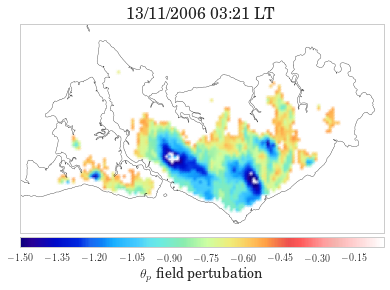

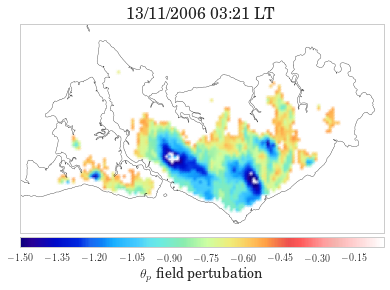

In [483]:
%matplotlib inline
from IPython import display as disp
from TintTrack import cold_pool_grids, creat_tracks
from mpl_toolkits.basemap import cm
import time as tt
first = True
fig=plt.figure(figsize=(9,4))
ax = fig.add_subplot(111)

first = True
vmin, vmax = 0, 0
cmap = cm.GMT_haxby
cmap.set_under('w')
cmap.set_bad('w')
#while True:
    #try:   
ii = 0
for s in slices:
    gr = (i for i in cold_pool_grids(nc(F), nc(R), s, lon, lat, maskfile=masF))
    for data in gr:
        ts = pd.Timestamp(data['time']).tz_localize(utc).tz_convert(timezone).tz_localize(None)
        if first:
            im = m.pcolormesh(lon, lat, -data['data'][0], vmax=-0.03, vmin=-1.5, cmap=cmap, shading='gouraud')
            cbar = m.colorbar(im, location='bottom')
            cbar.set_label('$\\theta_p$ field pertubation', fontsize=14)
            m.drawcoastlines(linewidth=0.3)
            first = False
        else:
            im.set_array(-data['data'][0].ravel())
        ax.set_title(ts.strftime('%_d/%_m/%Y %H:%M LT'), fontsize=16)
        fig.canvas.draw()
        disp.clear_output(wait=True)
        disp.display(plt.gcf())
        fname = os.path.join(outdir, 'ColdPool_%05i.png'%ii)
        fig.savefig(fname, bbox_inches='tight', format='png', dpi=72)
        tt.sleep(0.2)
        ii += 1

                
    #except KeyboardInterrupt:
    #    da = ax.cla(), fig.clf(), plt.close()
    #    break
    
   
d=disp.clear_output(wait=True)
d= disp.display(plt.gcf())
dest_dir = os.path.abspath('Vid')
make_mp4_from_frames(outdir, dest_dir, 'ColdPool-Ens-1.mp4', 4, glob='ColdPool_?????')

In [485]:
embed_vid(os.path.join(dest_dir, 'ColdPool-Ens-2.mp4'))

In [484]:
embed_vid(os.path.join(dest_dir, 'ColdPool-Ens-1.mp4'))

In [306]:
UM133_pdf_c, UM044_pdf_c= ravel(UM133_ens, 'UM 1.33km'), ravel(UM044_ens, 'UM 0.44km')
df_stack = pd.concat([UM133_pdf_c, UM044_pdf_c], ignore_index=True)

#df_stack['avg_area'] /= 2.5**2
df_stack['cp_area'].loc[(df_stack['quant']==3) & (df_stack['run']=='UM 1.33km')] *= 0.8
df_stack['cp_area'].loc[(df_stack['quant']==4) & (df_stack['run']=='UM 1.33km')] *= 0.7
df_stack['cp_area'].loc[(df_stack['quant']==5) & (df_stack['run']=='UM 1.33km')] *= 0.5
df_stack['cp_mean'].loc[df_stack['run']=='UM 1.33km'] *= 0.8
df_stack['cp_dur'] *= 0.25
#df_stack['quant'] = df_stack['quant'].astype('i')

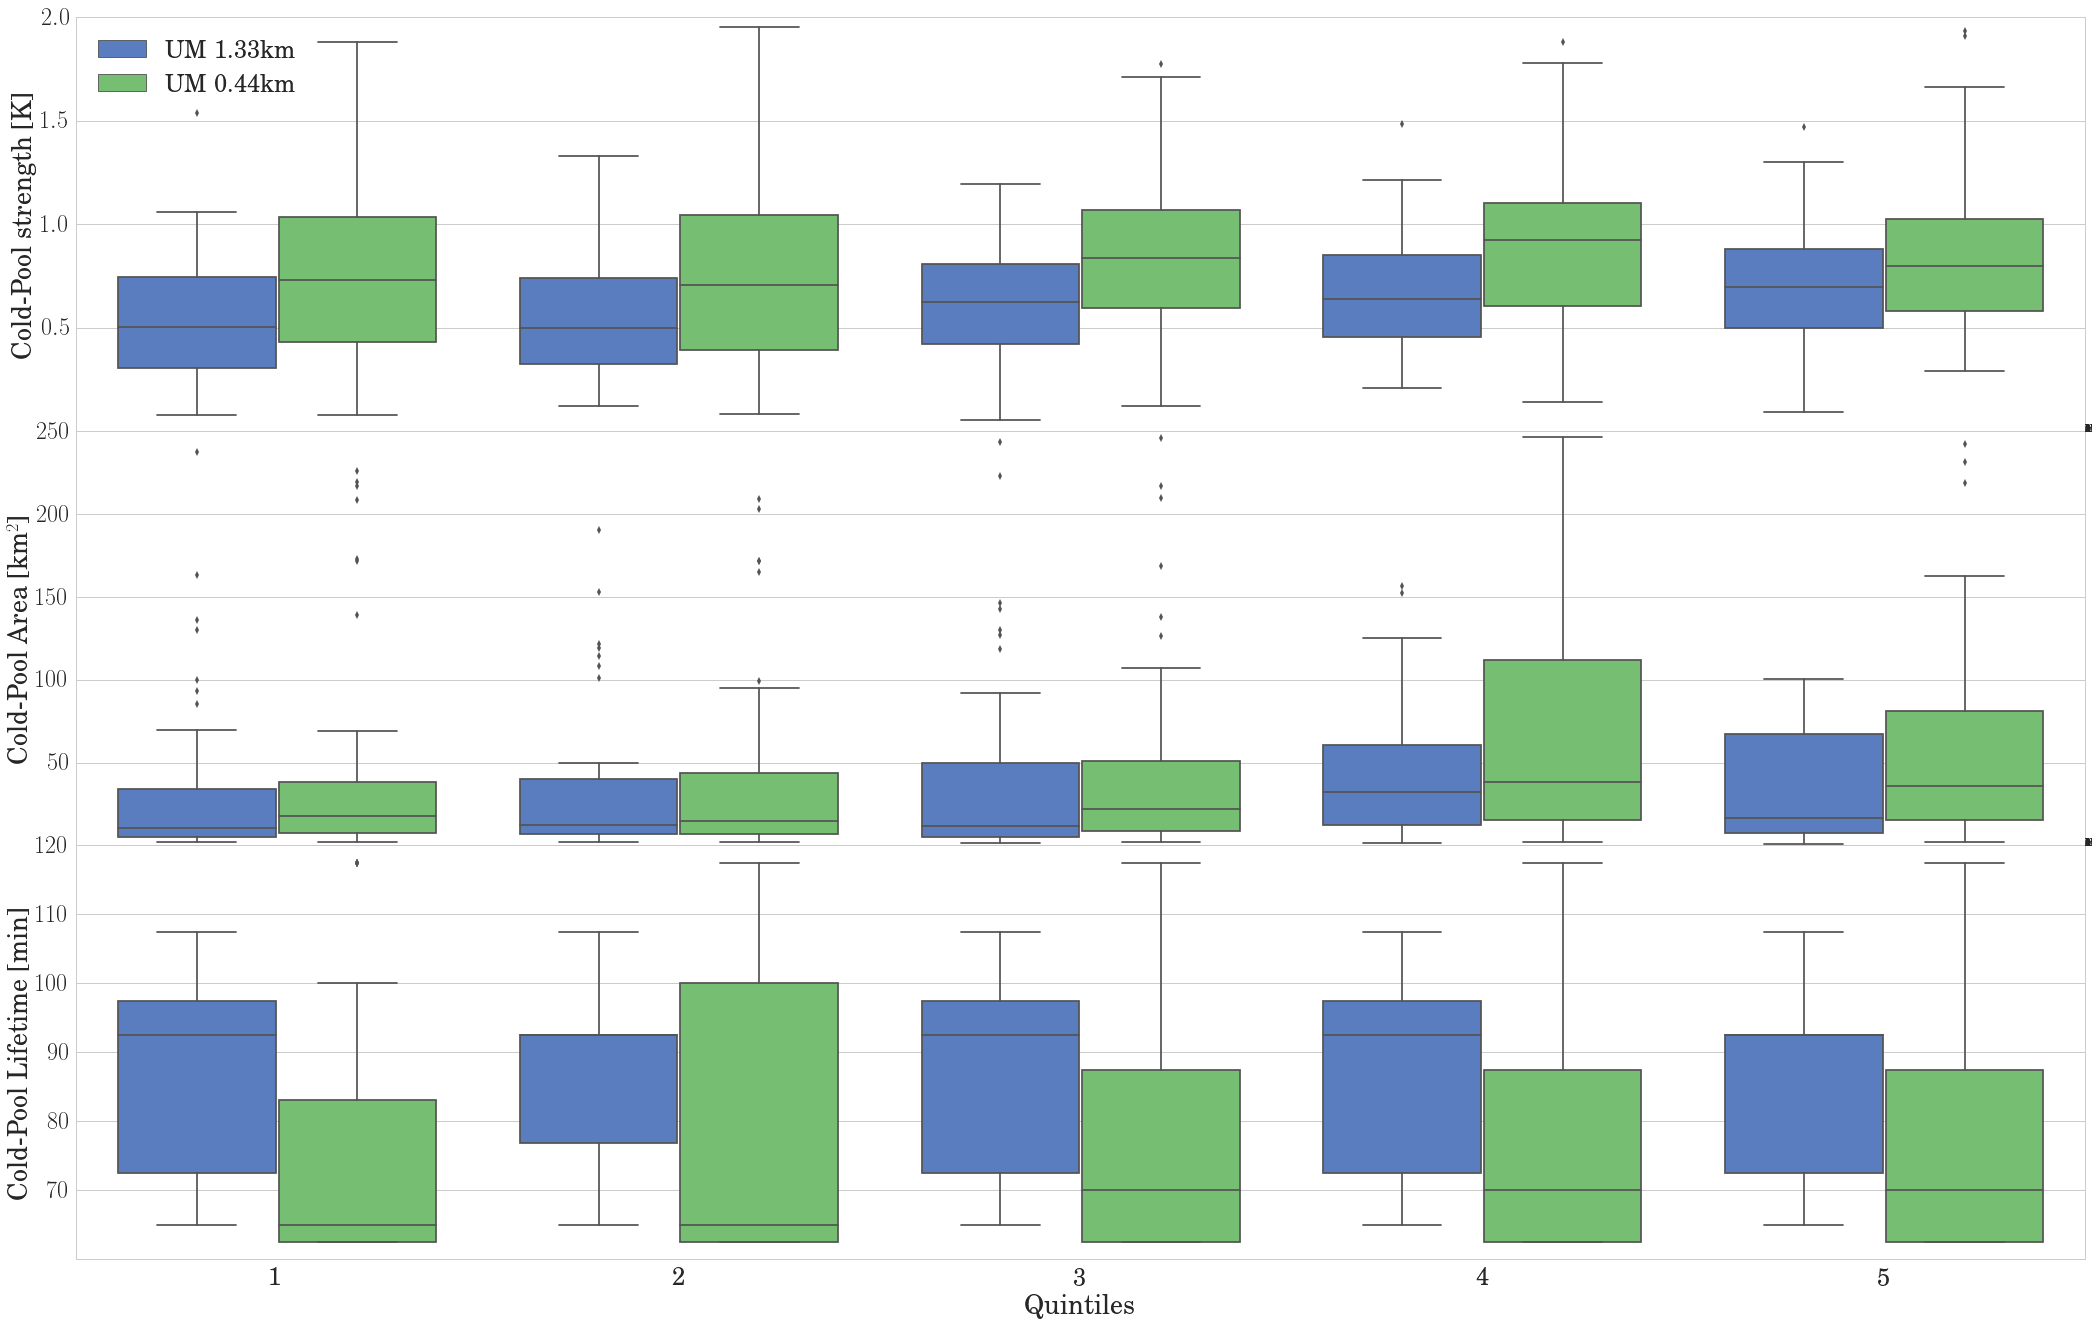

In [367]:
mpld3.disable_notebook()
variables=dict(cp_area=('Cold-Pool Area [km$^2$]', 220), cp_mean=('Cold-Pool strength [K]', 2), 
               cp_dur=('Cold-Pool Lifetime [min]', 120))
fig = plt.figure()
fig.subplots_adjust(right=0.94, bottom=0.025, top=0.6,left=0.01, hspace=0, wspace=0)
i = 0
for y, prop in variables.items():
    label, ylim = prop
    npl = len(list(variables.keys()))
    i += 1
    ax = fig.add_subplot(npl,1,i)
    ax = sns.boxplot(x="quant", y=y, hue="run", data=df_stack, palette="muted", ax=ax)
    #ax = sns.stripplot(x="quant", y=y, hue="run", data=df_stack, jitter=True, palette="Set2", dodge=True)
    if i == 1:
        ax.legend(loc=0, fontsize=24)
    else:
        ax.legend(loc=0, fontsize=0.001)
    ax.tick_params(labelsize=24)
    ax.set_xlim(0.5,5.5)
    if i == 3:
        ax.set_ylim(60,ylim)
    else:
        ax.set_ylim(0, ylim)
    ax.yaxis.set_ticks(ax.yaxis.get_ticklocs()[1:])
    ax.set_xlabel('Quintiles', fontsize=26)
    ax.set_ylabel(label, fontsize=26)
    #break
#fig.savefig(os.path.join(os.environ['HOME'], 'Todds_Rainfall_2.pdf'), bbox_inches='tight', format='pdf', dpi=300)

### Fluxes

In [440]:
#Get Storm properties
storm_prop = {'omega': [], 'momflux': [], 'moistflux': [], 'bflux': [], 'uid': [], 'run': [], 'precip': [],
              'quant': [], 'ens':[], 'cloud_z' :[], 'q': [], 'ctt':[], 'mfluxdiv':[]}
lookup = {'UM044':'UM 0.44km', 'UM133':'UM 1.33km'}
z=np.linspace(5, 9000, 22)
plev = (800, 600)
for ens in ensembles:
    with h5py.File(os.path.join(UMdir,'Storm_prop-%s.hdf5'%ens.replace('T',''))) as h5:
        P = h5['p'][:]
        pidx = (h5['p'][:] <= plev[0]) & (h5['p'][:] >= plev[-1]) 
        for res, resl in lookup.items():
            gr = h5['%s/%s'%(res, ens.replace('T',''))]
            for uid in gr['uids'][:]:
                
                storm_prop['omega'].append(gr['%04i/omega'%uid][:].max(axis=0).mean())
                storm_prop['bflux'].append(gr['%04i/bflux'%uid][:].sum(axis=0).mean())
                storm_prop['moistflux'].append(gr['%04i/mflux'%uid][:].sum(axis=0).mean())
                storm_prop['momflux'].append(gr['%04i/momflux'%uid][:].sum(axis=0).mean()/10)
                storm_prop['mfluxdiv'].append(gr['%04i/mfluxdiv'%uid][:].sum(axis=0).mean()*1000)
                storm_prop['run'].append(lookup[res])
                storm_prop['precip'].append(gr['%04i/rain'%uid].value)
                cl = gr['%04i/cloud_z'%uid][:].mean(axis=(-2,-1))
                storm_prop['q'].append(gr['%04i/q'%uid][:].mean())
                ctt = gr['%04i/ctt'%uid][:]
                ctt[ctt>0] = np.nan
                storm_prop['ctt'].append(np.nanmean(ctt))
                cl[cl<1e-5] = np.nan
                zz = z[10:][np.nanargmin(cl[10:])]
                storm_prop['cloud_z'].append(zz/1000. + 1)#np.random.ranf(1)[0])
                storm_prop['uid'].append(uid)
                storm_prop['quant'].append(0)
                storm_prop['ens'].append(ens.replace('T',''))
                #print(storm_prop)
                #break
            #break
    #break
storm_prop = get_quant(pd.DataFrame(storm_prop), rain='precip')

In [441]:
fluxes044 = {'bflux':{i:[] for i in range(1,6)}, 'mflux':{i:[] for i in range(1,6)}, 
             'momflux':{i:[] for i in range(1,6)}, 'omega': {i:[] for i in range(1,6)},
             'mfluxdiv': {i:[] for i in range(1,6)}, 'q': {i:[] for i in range(1,6)}}
fluxes133 = {'bflux':{i:[] for i in range(1,6)}, 'mflux':{i:[] for i in range(1,6)}, 
             'momflux':{i:[] for i in range(1,6)}, 'omega': {i:[] for i in range(1,6)},
             'mfluxdiv': {i:[] for i in range(1,6)}, 'q': {i:[] for i in range(1,6)}}
lookup
for i in storm_prop.index:
    
    with h5py.File(os.path.join(UMdir,'Storm_prop-%s.hdf5'%storm_prop.loc[i]['ens'])) as h5:
        if storm_prop.loc[i].run == 'UM 1.33km':
            fluxes = fluxes133
            name='UM133'
        else:
            fluxes = fluxes044
            name='UM044'
        try:
            gr = h5['%s/%s/%04i'%(name,storm_prop.loc[i]['ens'], storm_prop.loc[i]['uid'])]
            for t in fluxes.keys():
                d=gr[t][:].mean(axis=(-2,-1))
                if len(d.shape) == 2:
                    d = d[0]
                fluxes[t][storm_prop.loc[i].quant].append(d)
        except KeyError:
            pass            

In [442]:
for k in fluxes044.keys():
    for i in range(1,6):
        fluxes044[k][i]=np.array(fluxes044[k][i]).mean(axis=0)
        fluxes133[k][i]=np.array(fluxes133[k][i]).mean(axis=0)

* Distributions of some variables

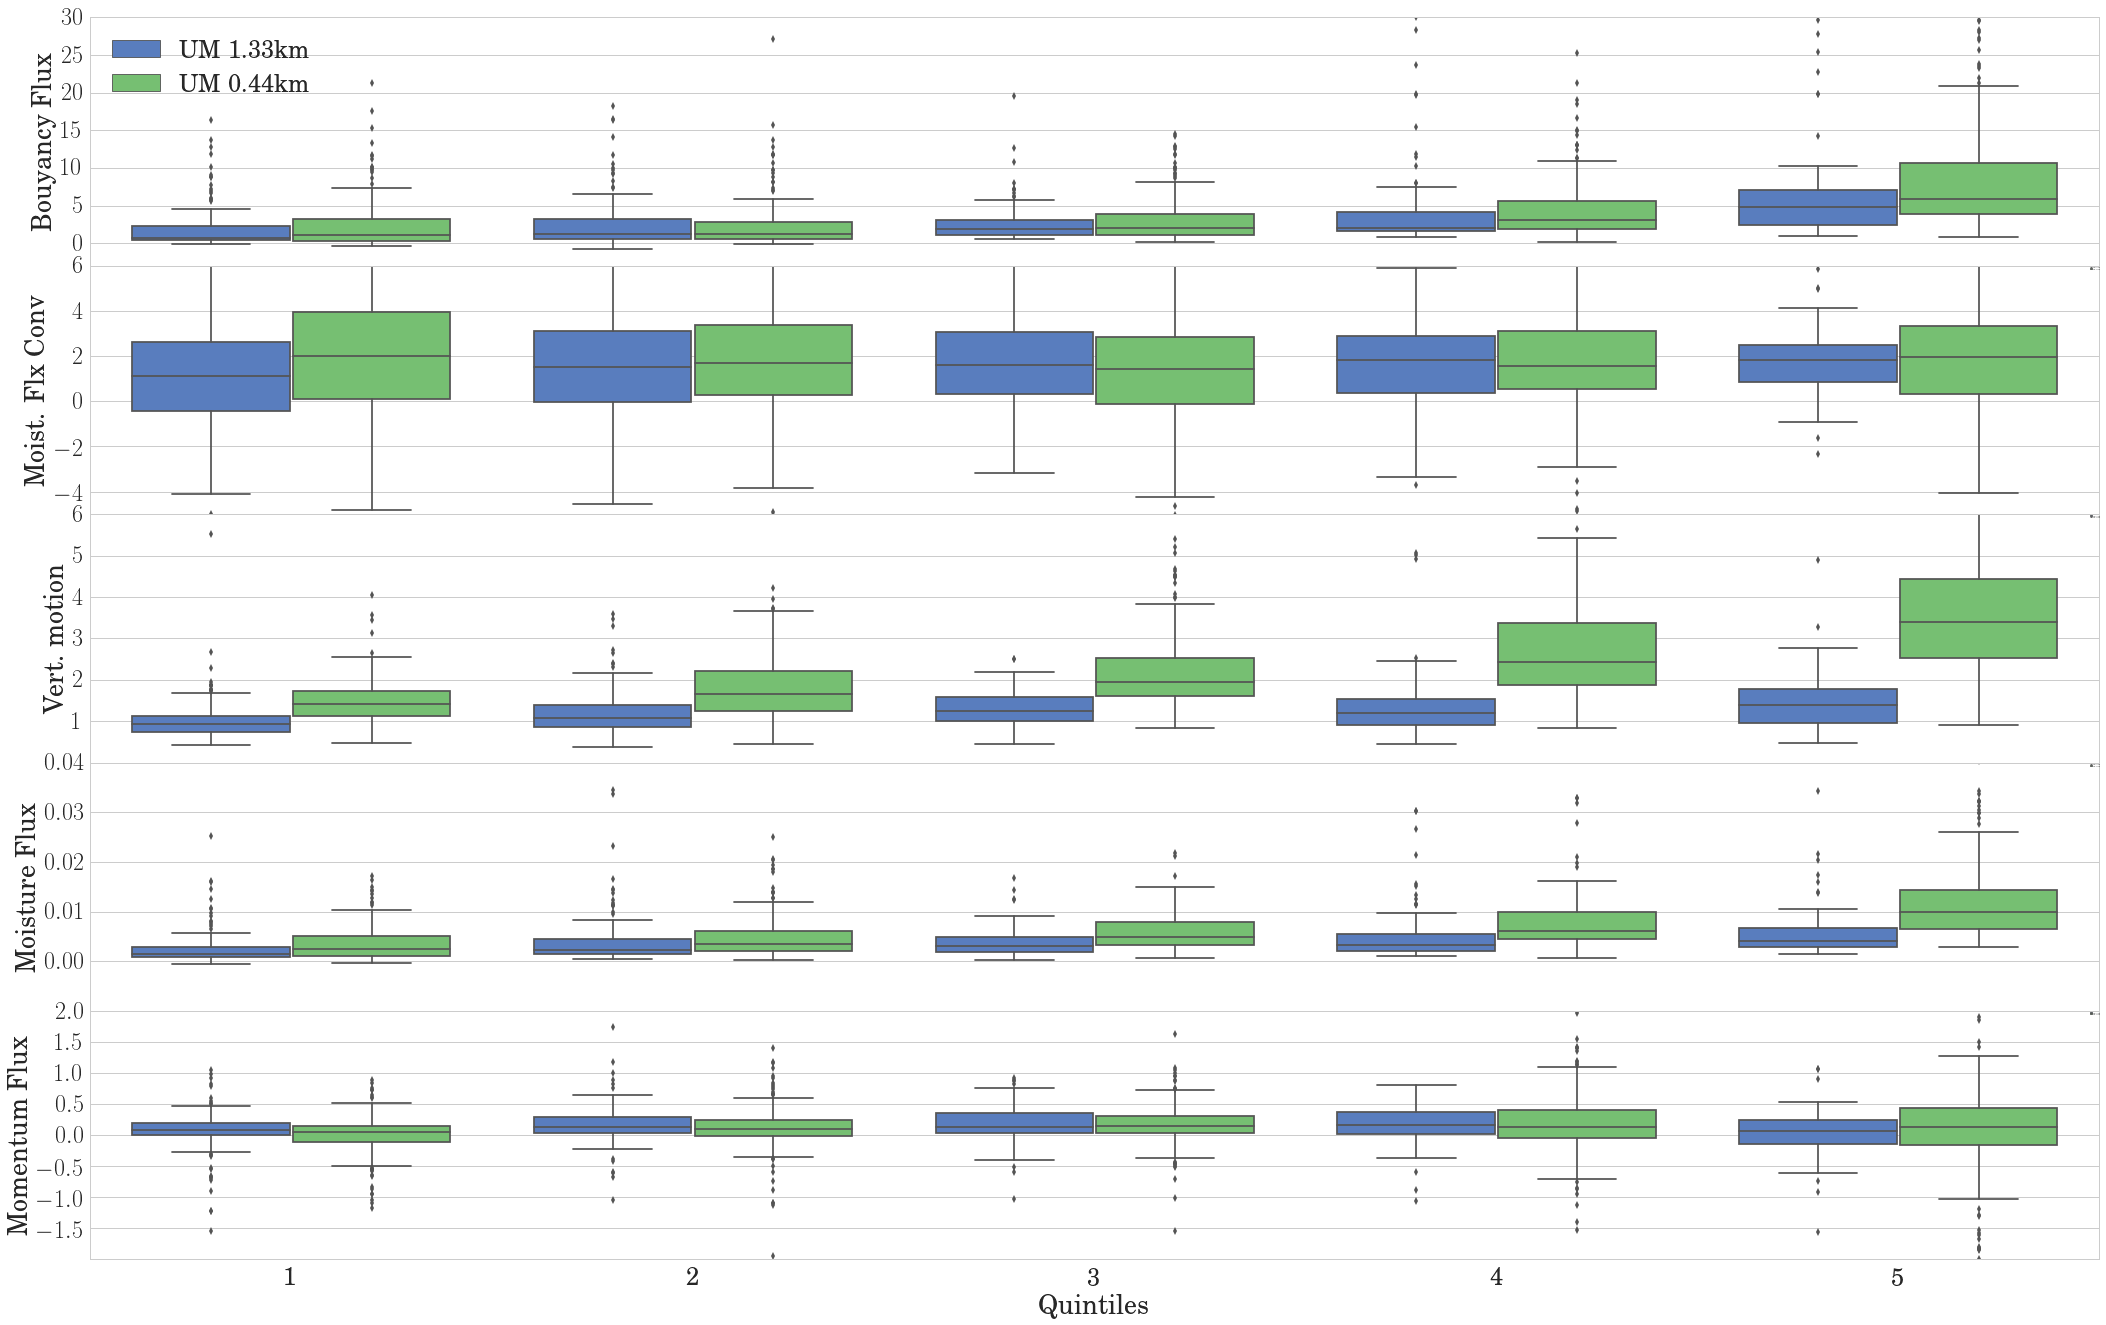

In [447]:
mpld3.disable_notebook()
variables=dict(omega=('Vert. motion', (0, 6)), bflux=('Bouyancy Flux', (-3,30)), mfluxdiv=('Moist. Flx Conv',(-5,6)),
               momflux=('Momentum Flux', (-2, 2)), moistflux=('Moisture Flux', (-0.01, 0.04)))
               #cloud_w=('Cloud Water', (0,0.005)))
fig = plt.figure()
fig.subplots_adjust(right=0.94, bottom=0.025, top=0.6,left=0.01, hspace=0, wspace=0)
i = 0
for y, prop in variables.items():
    label, ylim = prop
    npl = len(list(variables.keys()))
    i += 1
    ax = fig.add_subplot(npl,1,i)
    ax = sns.boxplot(x="quant", y=y, hue="run", data=storm_prop, palette="muted", ax=ax)
    #ax = sns.stripplot(x="quant", y=y, hue="run", data=df_stack, jitter=True, palette="Set2", dodge=True)
    if i == 1:
        ax.legend(loc=2, fontsize=24)
    else:
        ax.legend(fontsize=1)
    ax.tick_params(labelsize=24)
    ax.set_xlim(0.5,5.5)
    ax.set_ylim(*ylim)
    ax.yaxis.set_ticks(ax.yaxis.get_ticklocs()[1:])
    ax.set_xlabel('Quintiles', fontsize=26)
    ax.set_ylabel(label, fontsize=26)

* Some vertical profiles

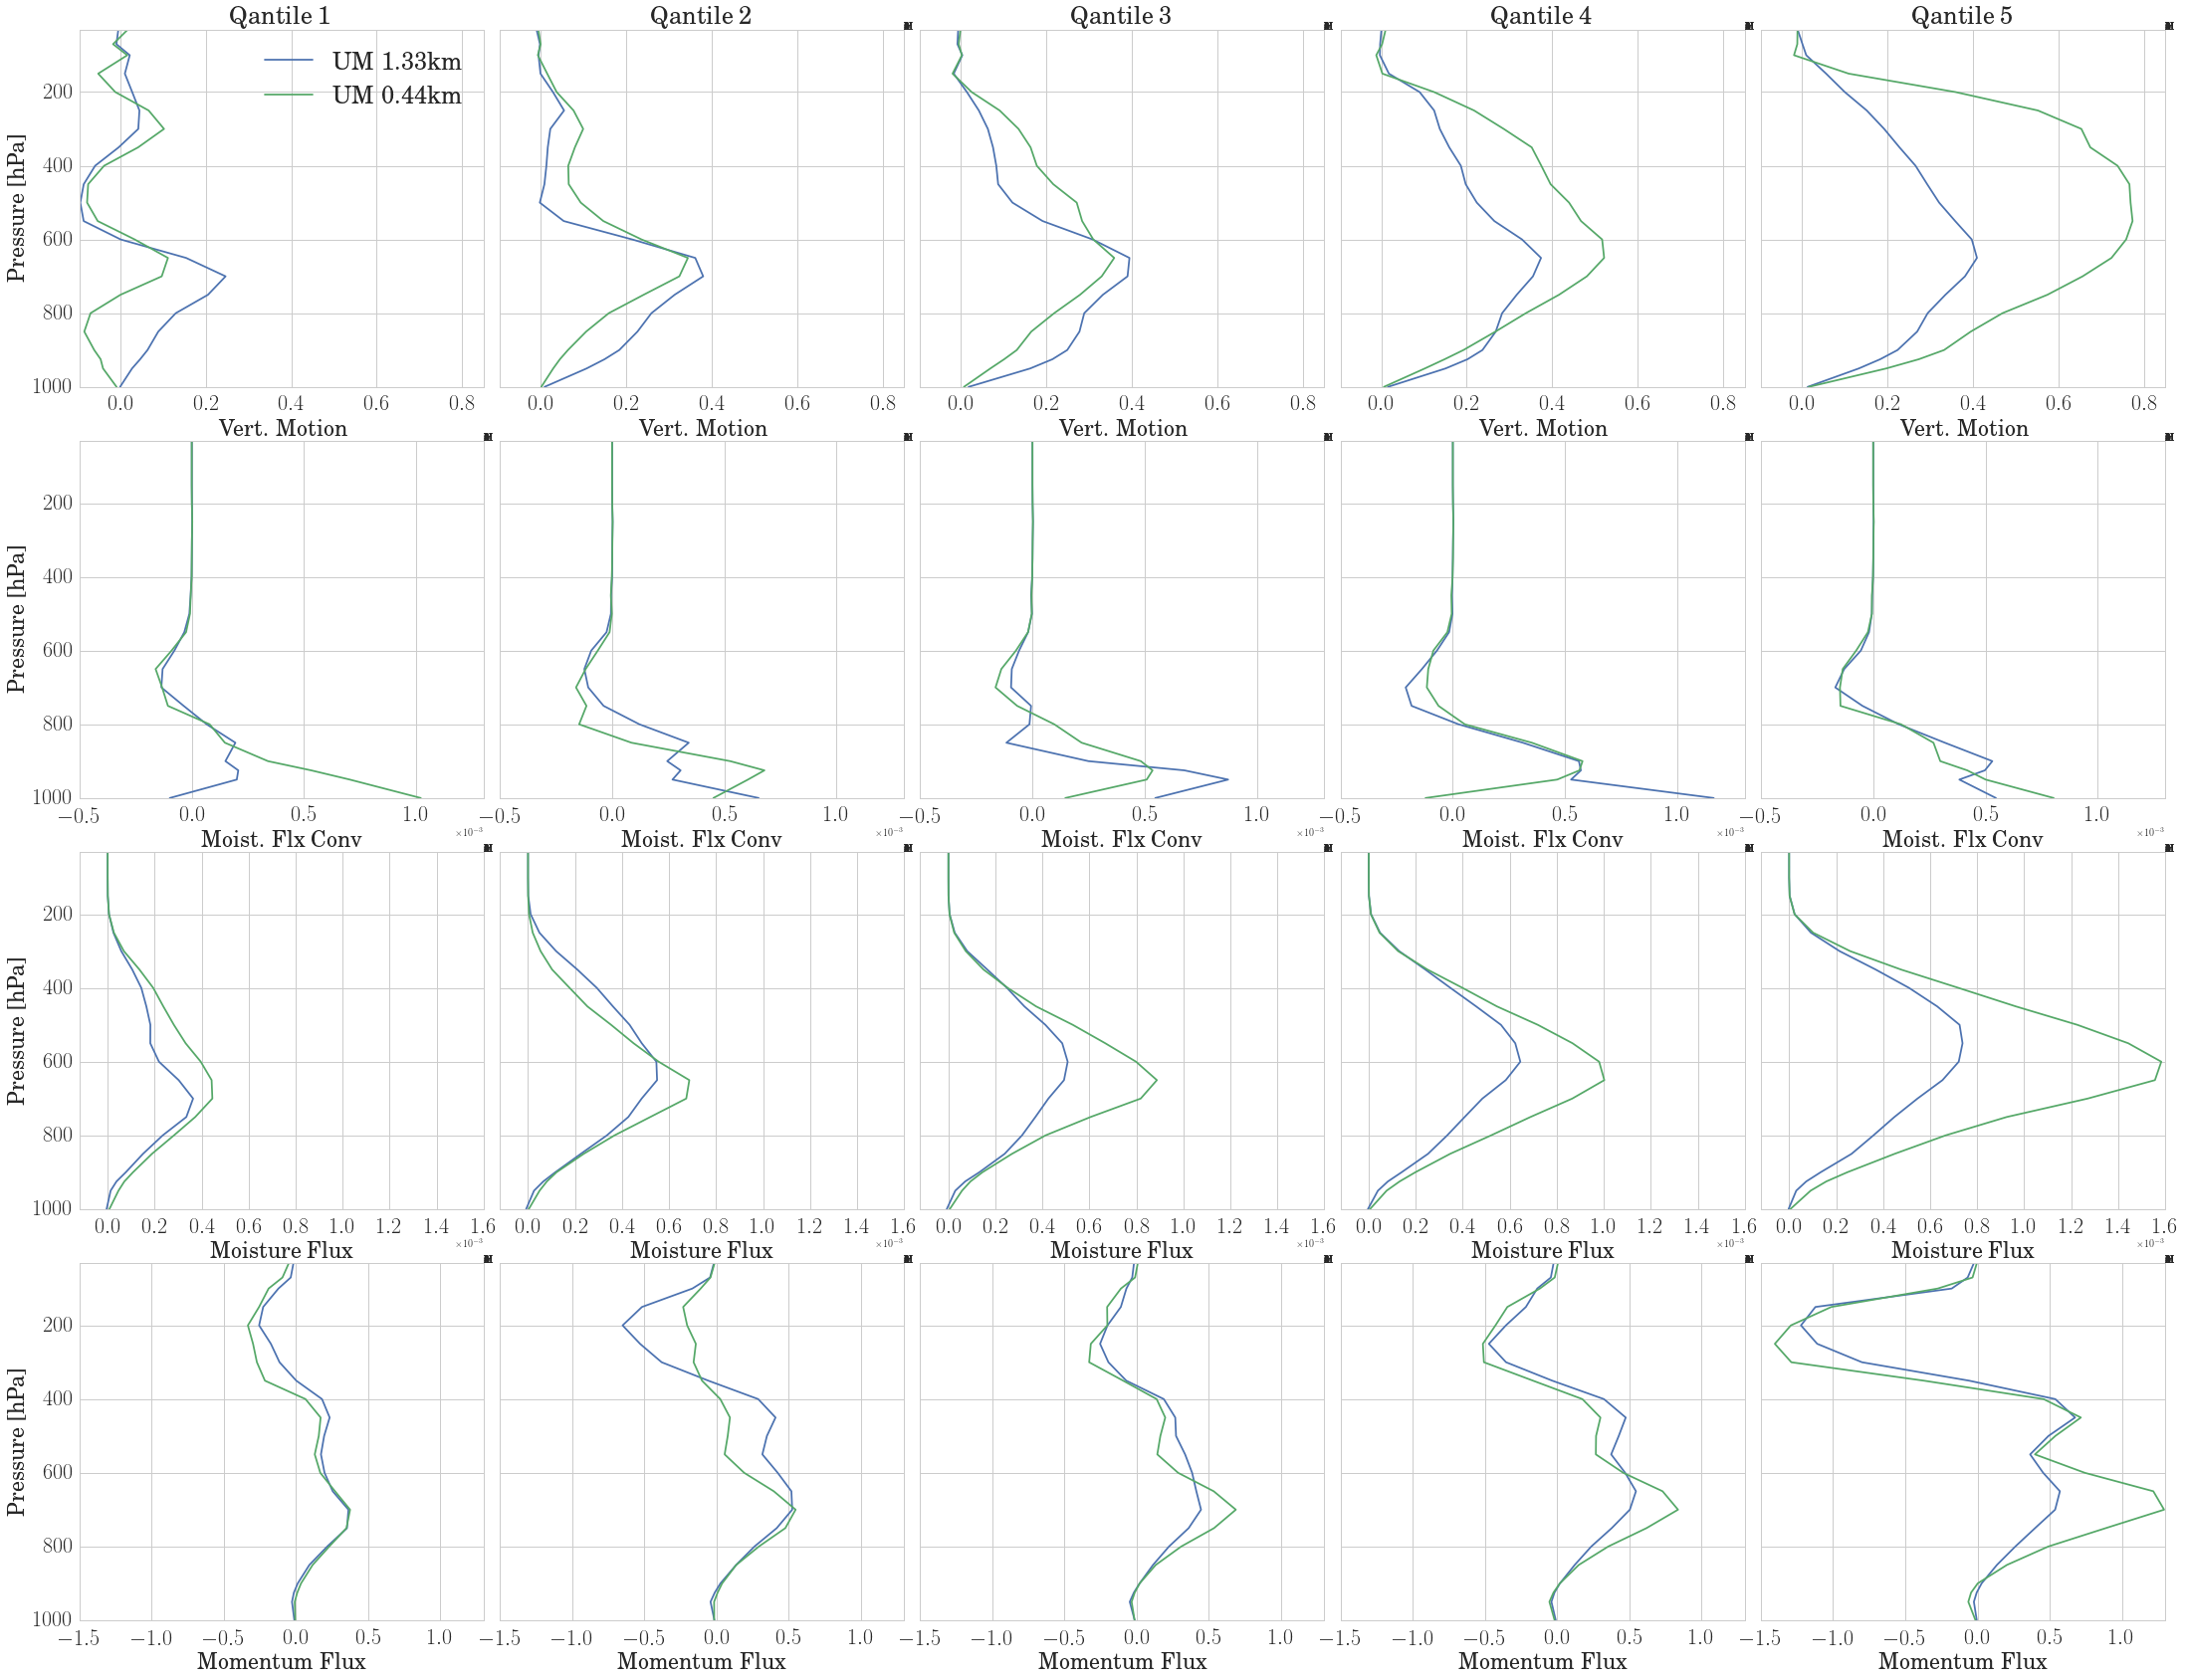

In [439]:
fig = plt.figure()
from matplotlib.ticker import Formatter

from scipy import interpolate
variables=dict( momflux=('Momentum Flux', (-1.5, 1.3)),
               mfluxdiv =('Moist. Flx Conv', (-0.5e-3,1.3e-3)),
               mflux=('Moisture Flux', (-1.2e-4, 1.6e-3)), omega=(('Vert. Motion'), (-9.5e-2, 8.5e-1)))
i = 0
fontsize=24
y = np.linspace(P[-1], P[0], 40)[::-1]
for x, prop in variables.items():
    label, xlim = prop
    npl = len(list(variables.keys()))
   
    for ii in range(1, 6):
        i += 1
        ax = fig.add_subplot(npl,5,i)
        for ff, fluxes in enumerate((fluxes133, fluxes044)):           
            flux = fluxes[x][ii]
            f = interpolate.interp1d(P, flux, kind='slinear')
            #xx = f(y)
            y = P
            xx = flux
            ax.plot(xx, y, label=('UM 1.33km', 'UM 0.44km')[ff])
            ax.set_ylim(max(y), min(y))
            ax.set_xlim(*xlim)
            if ii == 1:
                ax.set_ylabel('Pressure [hPa]', fontsize=fontsize-2)
            else:
                ax.yaxis.set_ticklabels([])   
            if i == 1:
                 ax.legend(loc=1, fontsize=fontsize)
            else:
                ax.legend(loc=1, fontsize=0.001)
            ax.set_xlabel(label, fontsize=fontsize-2)
            ax.tick_params(labelsize=fontsize-2)
            ax.ticklabel_format(axis='x', style='sci')
            if i < 6:
                ax.set_title('Qantile  %i'%ii, fontsize=fontsize)
            #ax.xaxis.set_major_formatter('%.1E')
            ax.ticklabel_format(style='sci', axis='x') 
            ax.xaxis.major.formatter.set_powerlimits((0,0))
fig.subplots_adjust(right=0.98, bottom=0.25, top=0.99, left=0.01, hspace=0.15, wspace=0.04)